# End-to-end simulation-based-inference (SBI) pipeline

This notebook shows how to perform an end-to-end cosmological analysis using a SBI pipeline. Using simulated maps of the convergence field (which is a typical observable in weak lensing) as a function of 2 cosmological parameters (omega_m and sigma_8), we will build a framework able to estimate the likelihood surface of having the data given the cosmological parameters. Then, provided some target maps, we will infer the posterior of the parameters using our pipeline.

We'll start loading into memory some simulated maps. These will be 64x64 pixels 2D patches representing the simulated convergence fields. We will have different patches as a function of 2 cosmological parameters (omega_m and sigma_8). In this case, to make things easier, the convergence field will be noiseless (usually we have the so called  shape-noise, which in first approx. is just a mean-zero Gaussian noise). The patches are relatively small (in real data, with noise, you'd need much larger patches to obtain something sensible).

Then we'll compress the data. This is done to facilitate the likelihood estimation. This will be performed in 2 ways:
1): using a CNN. This will compress the 2D patches down to 2 numbers (which are the parameters we care about)
2): using some intermediate summary statistics, like 2nd moments. The intermediate summary statistics are useful because they're easier to interpret. So we will compute second moments for each patch as a function of some smoothing scale. We will then also compress these second moments using linear regression down to 2 numbers (which are the parameters we care about).

Then we will estimate the likelihood surface using some neural density estimators. We will then sample the likelihood surface at different location of the parameter space given some target maps, and we will use that to estimate the posterior of the cosmological parameters of the target map




# Load the Data


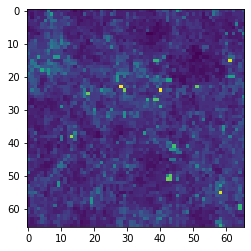

You can appreciate different subtructures in this patch. The peaks in the maps represent  overdense structures in the simulations, i.e., clusters of matter. Blue regions are underdense regions, like voids. The way these structures are clustered and their size depends on the cosmological parameters we want to infer.


# samples used for training: 80000
# samples used for validation: 10000
# samples used for testing: 10000
# total samples: 100000
(80000, 66, 66) (10000, 66, 66) (10000, 66, 66)
(80000, 6) (10000, 6) (10000, 6)


let s show the parameter space spanned by the simulation


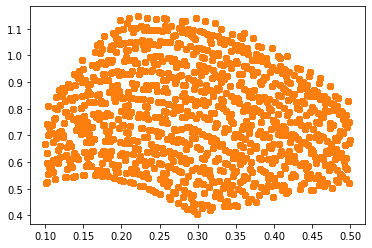

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# load cosmological parameters -------
# Omega_m, H0, ns, sigma_8, w, omega_b . We just care about omega_m and sigma_8 for the moment


####Yvals = np.load("../y_maps_Cosmogrid_100k.npy", allow_pickle=True)
####
##### patches
####Xvals = np.load("../X_maps_Cosmogrid_100k.npy", allow_pickle=True)


Yvals = np.load("/global/cfs/cdirs/des/shubh/transformers/ViT_weak_lensing/data/6-parameter-maps/y_maps_Cosmogrid_100k.npy", allow_pickle=True)
# Usually cosmologists use S8 instead of sigma_8, which is defined as S8 = sigma_8 * np.sqrt(omega_m/0.3).
# this change of variable is done because it's the "direction" best constrained by weak lensing.
Yvals[:,3] = Yvals[:,3]*np.sqrt(Yvals[:,0]/0.3)


# patches
Xvals = np.load("/global/cfs/cdirs/des/shubh/transformers/ViT_weak_lensing/data/6-parameter-maps/X_maps_Cosmogrid_100k.npy", allow_pickle=True)


# show a patch -----
plt.imshow(Xvals[0])
plt.show()
'''
You can appreciate different subtructures in this patch. The 'peaks' in the maps represent 
overdense structures in the simulations, i.e., clusters of matter. Blue regions are underdense regions, like voids.
The way these structures are clustered and their size depends on the cosmological parameters we want to infer.
'''
print ('You can appreciate different subtructures in this patch. The peaks in the maps represent  overdense structures in the simulations, i.e., clusters of matter. Blue regions are underdense regions, like voids. The way these structures are clustered and their size depends on the cosmological parameters we want to infer.')
print ('')
print ('')
# number of samples
num_samples = len(Yvals)

# split the sample for training ----------
train_split, val_split, test_split = int(0.80*num_samples), \
            int(0.10*num_samples), int(0.10*num_samples)
    
print('# samples used for training:', train_split)
print('# samples used for validation:', val_split)
print('# samples used for testing:' ,test_split)
print('# total samples:', train_split+val_split+test_split)


train_x, val_x, test_x = np.split(Xvals, [train_split, train_split+val_split])
train_y, val_y, test_y = np.split(Yvals, [train_split, train_split+val_split])

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y.shape, val_y.shape, test_y.shape)


params_mask = np.array([True,False,False,True,False,False])
output_num = len(params_mask[params_mask])

# let's focus on omega_m and sigma_8 
train_y, val_y, test_y = train_y[:,params_mask], val_y[:,params_mask], test_y[:,params_mask]

# let's show the parameter space spanned by the simulation
print ('')
print ('')
print ('let s show the parameter space spanned by the simulation')
plt.scatter(train_y[:,0],train_y[:,1])
plt.scatter(val_y[:,0],val_y[:,1])
plt.ylabel('S8')
plt.xlabel('Omega_m')



# Compression 1: CNN

Let's compress the maps using the CNN to do a simple linear regression of the cosmological parameters

In [ ]:
import torch
import torch.nn as nn
import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # self.normalization = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4)
        self.relu1 = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 48, kernel_size=4)
        self.relu3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1200, 128)
        self.relu4 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu5 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu6 = nn.LeakyReLU()
        self.fc4 = nn.Linear(32, output_num)
        
    def forward(self, x):
        # x = self.normalization(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        x = self.relu6(x)
        x = self.fc4(x)
        return x

model = Model()

# Print the model summary
print(model)


# Convert data into torch format
import torch
import torch.nn as nn
import torch.optim as optim
epochs = 2
batch_size = 8

# Create DataLoader for batching the data
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_x[:, None, :, :]), torch.from_numpy(train_y[:]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_x[:, None, :, :]), torch.from_numpy(val_y))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_x[:, None, :, :]), torch.from_numpy(test_y))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)





def train_model(model, 
                data_loader, 
                val_loader,
                dataset_size, 
                val_size, 
                optimizer, 
                num_epochs):
    model.to(device)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        if epoch % 10 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
        model.train()

        running_loss = 0.0
        # Iterate over data.
        for bi, (inputs, labels) in enumerate(tqdm.tqdm(train_loader)):
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / dataset_size
        if epoch % 10 == 0:
            print('Loss: {:.4f}'.format(epoch_loss))
        
        if epoch % 10 == 0:
            model.eval()
            running_loss = 0.0
            # Iterate over data.
            for bi, (inputs, labels) in enumerate(tqdm.tqdm(val_loader)):
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)

                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
            epoch_val_loss = running_loss / val_size
            print('Val Loss: {:.4f}'.format(epoch_val_loss))
    return model

learning_rate = 0.001
weight_decay_rate = 0.01

optimizer = optim.AdamW(model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay_rate)

model = train_model(model, train_loader, val_loader, len(train_y), len(val_y), optimizer, 100)

In [4]:
torch.save(model.state_dict(), './CNN_mass_maps.pth')
model1 = Model()
model1.load_state_dict(torch.load('./CNN_mass_maps.pth'))


<All keys matched successfully>

100%|██████████| 1250/1250 [00:01<00:00, 953.09it/s]


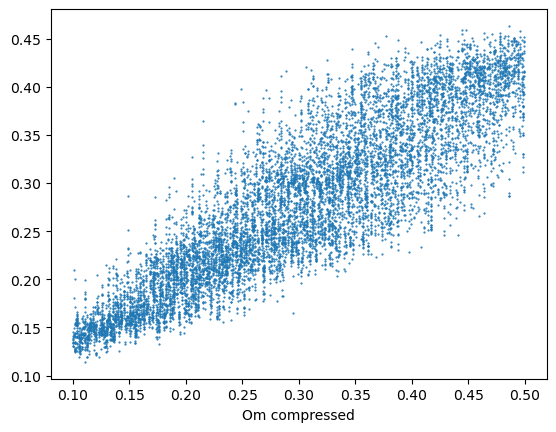

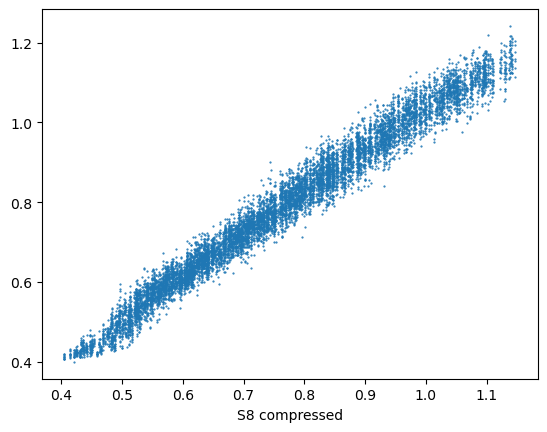

In [6]:

preds = np.empty((len(val_y), output_num))

model.eval()
for bi, (inputs, labels) in enumerate(tqdm.tqdm(val_loader)):
    inputs = inputs.to(device, dtype=torch.float)
    outputs = model(inputs)
    preds[bi*8 : (1+bi)*8] = outputs.detach().cpu().numpy()
        
preds.shape

plot_x, plot_y = val_x, val_y
predictions = preds
upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)


# plot predictions
plt.scatter(val_y[:,0],predictions[:,0],s=0.3)
plt.xlabel('Om sims')
plt.xlabel('Om compressed')
plt.show()

plt.scatter(val_y[:,1],predictions[:,1],s=0.3)
plt.xlabel('S8 sims')
plt.xlabel('S8 compressed')
plt.show()


# store all the info  for LFI:
info_CNN = dict()
info_CNN['params'] = val_y
info_CNN['compressed_DV'] = predictions
np.save('info_CNN',info_CNN)

# compression 2: moments


Let's now use some summary statistics ~ the second and third moments. Second and third moments are easy to compute, they are just the average of the second and third power of the pixel values. They can be computed at different smoothing scales. They probe the power spectrum and bispectrum of the maps. Let's first compute them and then compress them

In [14]:

def compute_second_moments(patch):
    # we smooth the field by groupong together adjacent pixels.
    # it's not the best way but it's a cheap method here
    moments = np.zeros(5)
    moments[0] = np.mean(patch**2)
    moments[1] = np.mean(((patch.reshape(2,2,33,33).sum(axis=1).sum(axis=2))/4)**2)
    moments[2] = np.mean(((patch.reshape(3,3,22,22).sum(axis=1).sum(axis=2))/9)**2)
    moments[3] = np.mean(((patch.reshape(6,6,11,11).sum(axis=1).sum(axis=2))/36)**2)
    moments[4] = np.mean(((patch.reshape(11,11,6,6).sum(axis=1).sum(axis=2))/121)**2)


    return moments

def compute_third_moments(patch):
    # we smooth the field by groupong together adjacent pixels.
    # it's not the best way but it's a cheap method here
    moments = np.zeros(5)
    moments[0] = np.mean(patch**3)
    moments[1] = np.mean(((patch.reshape(2,2,33,33).sum(axis=1).sum(axis=2))/4)**3)
    moments[2] = np.mean(((patch.reshape(3,3,22,22).sum(axis=1).sum(axis=2))/9)**3)
    moments[3] = np.mean(((patch.reshape(6,6,11,11).sum(axis=1).sum(axis=2))/36)**3)
    moments[4] = np.mean(((patch.reshape(11,11,6,6).sum(axis=1).sum(axis=2))/121)**3)


    return moments




moments_2nd_train = np.array([compute_second_moments(train_x[i]) for i in range(80000)])
moments_2nd = np.array([compute_second_moments(val_x[i]) for i in range(10000)])

moments_3rd_train = np.array([compute_third_moments(train_x[i]) for i in range(80000)])
moments_3rd = np.array([compute_third_moments(val_x[i]) for i in range(10000)])



info_moments = dict()
info_moments['final_dv_train'] = np.hstack([moments_2nd_train,moments_3rd_train])
info_moments['params_train'] = train_y

info_moments['final_dv'] = np.hstack([moments_2nd,moments_3rd])
info_moments['params'] = val_y

In [15]:
import sys
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
sys.path.insert(0, "/project/projectdirs/des/mgatti/tensorflow_115/")
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_probability//")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
#
#
def simple_model_2d_100(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(90, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(80, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(10, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(10, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model

Train on 75000 samples, validate on 5000 samples
Epoch 1/10
75000/75000 [==============================] - 5s 72us/sample - loss: 0.0741 - val_loss: 0.0245
Epoch 2/10
75000/75000 [==============================] - 5s 69us/sample - loss: 0.0167 - val_loss: 0.0154
Epoch 3/10
75000/75000 [==============================] - 5s 70us/sample - loss: 0.0153 - val_loss: 0.0145
Epoch 4/10
75000/75000 [==============================] - 5s 70us/sample - loss: 0.0144 - val_loss: 0.0136
Epoch 5/10
75000/75000 [==============================] - 5s 70us/sample - loss: 0.0135 - val_loss: 0.0128
Epoch 6/10
75000/75000 [==============================] - 5s 70us/sample - loss: 0.0128 - val_loss: 0.0121
Epoch 7/10
75000/75000 [==============================] - 5s 70us/sample - loss: 0.0121 - val_loss: 0.0114
Epoch 8/10
75000/75000 [==============================] - 5s 70us/sample - loss: 0.0114 - val_loss: 0.0107
Epoch 9/10
75000/75000 [==============================] - 5s 70us/sample - loss: 0.0109 - val_l

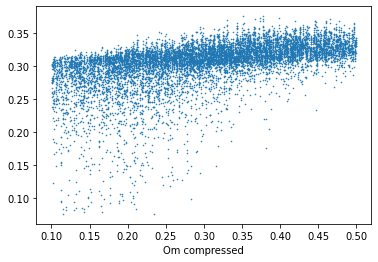

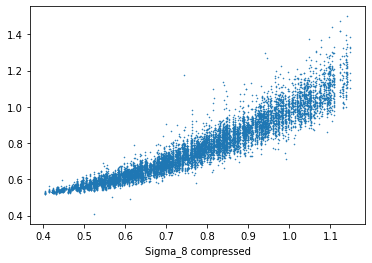

In [16]:
import os


# normalise the data
sim_data =  np.clip(0.5+0.2 * (info_moments['final_dv_train']-np.median(info_moments['final_dv_train'],axis=0)) / np.std(info_moments['final_dv_train'], axis=0) ,-0.5,1.5)
sim_data_val =  np.clip(0.5+0.2 * (info_moments['final_dv']-np.median(info_moments['final_dv_train'],axis=0)) / np.std(info_moments['final_dv_train'], axis=0) ,-0.5,1.5)
par_labels = ['om','S8']

 
# compress!
for par, label_run in enumerate(par_labels):
    regression_power = simple_model_2d_100(info_moments['final_dv_train'].shape[1], lr=1e-5)

    #validation set 
    special_ = np.arange(info_moments['final_dv_train'].shape[0])<5000
    number_of_iter = 3 # usually after a few epochs it doesn't improve anymore.

    for i in range(number_of_iter):

        # add some noise to avoid overfitting -----
        numerical_noise = np.random.normal(sim_data*0.,2e-3)
        history_2d_power = regression_power.fit((sim_data+numerical_noise)[~special_],
                           info_moments['params_train'][~special_,:][:,par],
                           epochs =10,batch_size = 32, shuffle=True,
                           validation_data = ((sim_data)[special_],
                                            info_moments['params_train'][special_,:][:,par]))


    compressed_data  = np.clip(regression_power.predict(sim_data_val), -1., 1.5)
    if par == 0:
        compressed_data0 = compressed_data
    else:
        compressed_data0 = np.hstack([compressed_data0,compressed_data])
    
    
info_moments['compressed_DV'] = compressed_data0
np.save('info_moments',info_moments)
# plot compressed statistics
plt.scatter(info_moments['params'][:,0],compressed_data0[:,0],s=0.3)
plt.xlabel('Om sims')
plt.xlabel('Om compressed')
plt.show()

plt.scatter(info_moments['params'][:,1],compressed_data0[:,1],s=0.3)
plt.xlabel('Sigma_8 sims')
plt.xlabel('Sigma_8 compressed')
plt.show()


As you can note, the regression works much worse with the second moments. That is expected. Second moments are not really sensible to Omega_m. They are better with sigma_8, but they'd usually require a bigger area. CNN ar emuch better..but remember we're not adding noise here, with realistic shape noise the CNN performance would be closer to the moments one (although still superior)

# Likelihood surface estimation using SBI/LFI (pydelfi)

In [19]:
# run chain with LFI
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
import pydelfi.priors as priors
import tensorflow as tf
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import emcee as mc
lower = np.array([0.1, 0.5])
upper = np.array([0.4, 1.4])

theta2d_expected_mean = [0.3, 0.75]
prior = priors.Uniform(lower, upper)

def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/a
    rray of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

result_dir = '../../../../../../../pscratch/sd/m/mgatti/temp2/'       


count = 0

info = dict()
info['CNN'] = np.load('info_CNN.npy',allow_pickle=True).item()
info['moments'] = np.load('info_moments.npy',allow_pickle=True).item()




Let's train the NDE

In [ ]:
count = 0
import copy
trained_NDEs = dict()
for xx,run_key in enumerate(['CNN','moments']):

    n_data = 2 # length compressed data vector
    nn = len(lower)
    base = count # any time you re-run it, please increase this by the number of NDEs. Otherwise you'd need to restart the notebook.
    count += 2
    NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=n_data, n_hiddens=[50,50], n_mades=2, act_fun=tf.tanh, index=base + 0),
            ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=n_data, n_hiddens=[50,50], n_mades=3, act_fun=tf.tanh, index=base + 1)]
            #ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_data1.shape[1], n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=base + 2),
            #ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_data1.shape[1], n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=base + 3)]



    pn = ['p{0}'.format(i) for i in range(nn)]


    import os
    try:
        os.mkdir(result_dir+'/'+str(base))
    except:
        pass
    try:
        os.system('rm '+result_dir+'/'+str(base)+'/*')
    except:
        pass

    DelfiEnsemble = delfi.Delfi(np.array(np.median(info[run_key]['compressed_DV'],axis=0), dtype = 'float'), prior, NDEs,
                                        param_limits = [lower, upper],
                                        param_names = pn, 
                                        results_dir = result_dir+'/'+str(base)+'/')
    #,False,False]
    params_ = copy.deepcopy(info[run_key]['params'])

    DelfiEnsemble.load_simulations(np.array(info[run_key]['compressed_DV'], dtype = 'float'),  params_ )
    DelfiEnsemble.train_ndes()
    
    trained_NDEs[run_key] = DelfiEnsemble

Training:  19%|█▉        | 97/500 [00:28<01:18,  5.16it/s, train loss=-.125, val loss=-.105]    

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//10/graph_checkpoint


Training:   1%|          | 3/500 [00:02<06:56,  1.19it/s, train loss=0.0771, val loss=0.101]

# Testing

In [ ]:
good_rel = []
for rel in range(1000):
    o = info['moments']['params'][rel][0]
    s = info['moments']['params'][rel][1]
    if (o-0.3)**2<0.03**2:
        if (s-0.8)**2<0.03**2:
            good_rel.append(rel)
rel = good_rel[0]

In [ ]:

posteriors = dict()
for xx,run_key in enumerate(['CNN','moments']):

    target = info[run_key]['compressed_DV'][rel]

    n_dim2d=nn
    n_burn2d=100
    n_steps2d = 10000
    n_walkers2d = nn * n_dim2d



    theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])




    def prior_term2d(theta2d):
        p_ = theta2d.T
        for i in range(len(p_)):
            if ((p_[i]<lower[i])|(p_[i]>upper[i])):
                return  - np.inf
        return  0.



    def log_posterior2d_temp(theta2d, data):
        return trained_NDEs[run_key].log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


    sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(target,))

    _ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

    posteriors[run_key] = sampler2d_.get_chain()

In [ ]:
import getdist
from getdist import plots, MCSamples
su = []
for xx,run_key in enumerate(['CNN','moments']):

    samples = MCSamples(samples=[posteriors[run_key][:,:,0].flatten(),posteriors[run_key][:,:,1].flatten()],
                    names = ['Om','s8'],labels = [r'\Omega_{\rm m}',r'S_8'],
                    label=run_key,
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})
    su.append(samples)


plt.figure(figsize=(4,4))
g = plots.get_subplot_plotter()
#g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)

g.triangle_plot(su,['Om','s8'],legend_loc='upper right' ,markers = [info['moments']['params'][rel][0],info['moments']['params'][rel][1]*np.sqrt(info['moments']['params'][rel][0]/0.3)]) #,shaded=True)


In [75]:
import glob
f = glob.glob('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv/ST/*')
len(f)

2888

In [36]:
info_moments['compressed_moments'] = compressed_data0
np.save('info_moments',info_moments)


In [1]:
import os
import torch

In [ ]:
import sys
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
sys.path.insert(0, "/project/projectdirs/des/mgatti/tensorflow_115/")
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_probability//")

import tensorflow as tf


from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
# Keras Layers
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU
     
    
#
# # using pytorch-1.13.1 environment
